In [347]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import re
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import ast
import matplotlib.cm as cm
# from matplotlib.colormaps import get_cmap
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import ClassifierChain
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import re
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import ast
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [22]:
filepath = r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\classif.txt"
with open(filepath, 'r') as file:
    content = file.read()
classif = ast.literal_eval(content)

# Function to update the df for higher categories (in place)
def recursive_update(df, classif):
    # Go through each item in the classification
    for key, value in classif.items():
        if isinstance(value, list):
            # First process subcategories (go deeper into the hierarchy)
            for v in value:
                if isinstance(v, dict):
                    # Recursively update subcategories first
                    recursive_update(df, v)
            
            # After processing subcategories, update the current category
            sub_categories = [v if isinstance(v, str) else list(v.keys())[0] for v in value]
            df.loc[df[sub_categories].eq(1).any(axis=1), key] = 1
    
    # Return the DataFrame to allow for chaining if needed
    return df


def prune_hierarchy(classif, valid_labels):
    """
    Recursively prune the classification hierarchy to include only valid labels.
    """
    pruned_classif = {}
    for key, value in classif.items():
        if key in valid_labels:
            if isinstance(value, list):
                pruned_value = []
                for v in value:
                    if isinstance(v, dict):
                        pruned_sub = prune_hierarchy(v, valid_labels)
                        if pruned_sub:  # Add only if not empty
                            pruned_value.append(pruned_sub)
                    elif v in valid_labels:
                        pruned_value.append(v)
                if pruned_value:  # Add key only if value is not empty
                    pruned_classif[key] = pruned_value
            else:
                pruned_classif[key] = value
    return pruned_classif

In [302]:
def add_hierarchy(classif, y, y_pred):
    valid_labels = set(y.columns)  # Labels remaining after filtering
    pruned_classif = prune_hierarchy(classif, valid_labels)
    y_pred_corrected = recursive_update(y_pred.copy(), pruned_classif)
    return y_pred_corrected

def evaluate_model(y, y_test, y_pred, suffix): 
    metrics = []

# Evaluate each label
    for label in y.columns:
        true_values = y_test[label]
        predictions = y_pred[label]
        
        metrics.append({
            "label": label,
            f"Precision_{suffix}": precision_score(true_values, predictions, zero_division=0),
            f"Recall_{suffix}": recall_score(true_values, predictions, zero_division=0),
            f"F1-Score_{suffix}": f1_score(true_values, predictions, zero_division=0),
            f"Accuracy_{suffix}": accuracy_score(true_values, predictions)
        })
    

    # Convert to DataFrame for easier analysis
    return pd.DataFrame(metrics).set_index("label").sort_index()

# Data

In [355]:
# regex results

filepath = r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\regex_metrics.csv"
regex_results = pd.read_csv(filepath, sep = ";")
regex_results = regex_results.drop(columns = ['Unnamed: 0'])
regex_results = regex_results.set_index('Category')
regex_results.index.name = 'label'
in_regression = [i for i in regex_results.index if i  in metrics_df.index]
regex_results = regex_results.loc[in_regression].sort_index()


# the data

df = pd.read_csv(r"C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\coding_trial\testData2711.csv")
df = df.drop(columns = 'Unnamed: 0')
df.head(2)

,PHENOTYPE,Phen_data,MORPH,quant_morph,interbr_morph,qual_morph,color_pattern,shape,texture,ultrastruct,...,phylogenetic,specimen_storage_loc,sampling_loc,abbrev_terms,nomenclat_history,biogeo,id,displayed_text,checked,batch
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,./Corpus/EJT/10_5852_ejt_2021_735_1243.json_0,The material examined was collected in fragmen...,0,batch1
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,./Corpus/Zootaxa/1/zootaxa_1920_1_5.json_0,Invertebrate samples\nwere collected using a h...,0,batch1


In [356]:
# preprocess

# Extract features and labels
X = df['displayed_text']  # Features (text field)
y = df.iloc[:, :-4]  # Assuming last 3 columns are metadata, adjust as needed

# Remove columns with only one class (all 0s or all 1s)
non_constant_columns = [col for col in y.columns if y[col].nunique() > 1]
y = y[non_constant_columns]

# vectorize text
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_vectorized = vectorizer.fit_transform(X)


# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=2808)


# Logistic Classifiers

In [357]:
# Train Binary Relevance Logistic Regression
models = {}
for label in y.columns:
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train[label])
    models[label] = model

# Evaluate on the test set
y_pred = pd.DataFrame(index=y_test.index)
for label, model in models.items():
    y_pred[label] = model.predict(X_test)

# add hierarchy info
# y_pred = add_hierarchy(classif, y, y_pred)
regr_metrics = evaluate_model(y, y_test, y_pred, 'regr')
regr_hamming = hamming_loss(y_test, y_pred)

# Classifier chain

In [358]:
# Initialize logistic regression and classifier chains
base_model = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")

# customize the order of the chain
# eg sparse first
y_copy = y.copy()
custom_order = regex_results.sort_values(by = 'Support', ascending =True).index
y_reordered = y_copy.reindex(columns=custom_order)


# get data again, but columns in different order
# Split into train/test sets
X_train_reordered, X_test_reordered, y_train_reordered, y_test_reordered = train_test_split(X_vectorized, y_reordered, test_size=0.2, random_state=2808)

# train the model
chain_model = ClassifierChain(base_model, order=None)
chain_model.fit(X_train_reordered, y_train_reordered)

# Predict on the test set
y_pred = pd.DataFrame(chain_model.predict(X_test_reordered), columns=y_test_reordered.columns, index=y_test_reordered.index)

# recursively update
# y_pred = add_hierarchy(classif, y_copy, y_pred)
chain_metrics = evaluate_model(y_reordered, y_test_reordered, y_pred, 'chain')
chain_hamming = hamming_loss(y_test_reordered, y_pred)


# Random Forest

In [359]:
# Train RF classif
models = {}
for label in y.columns:
    model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed
    model.fit(X_train, y_train[label])
    models[label] = model

# Step 3: Predict on Test Set
y_pred = pd.DataFrame(index=y_test.index)
for label, model in models.items():
    y_pred[label] = model.predict(X_test)

# recursively update
# y_pred = add_hierarchy(classif, y, y_pred)
rf_metrics = evaluate_model(y, y_test, y_pred, 'rf')
rf_hamming = hamming_loss(y_test, y_pred)


# Naive Bayes

In [360]:
# Step 2: Train Binary Relevance Naive Bayes Classifier
models = {}
for label in y.columns:
    model = MultinomialNB()
    model.fit(X_train, y_train[label])
    models[label] = model

# Step 3: Predict on Test Set
y_pred = pd.DataFrame(index=y_test.index)
for label, model in models.items():
    y_pred[label] = model.predict(X_test)

# recursively update
# y_pred = add_hierarchy(classif, y, y_pred)
nb_metrics = evaluate_model(y, y_test, y_pred, 'nb')
nb_hamming = hamming_loss(y_test, y_pred)



# Gradient boosting

In [361]:
# Step 2: Train Binary Relevance Gradient Boosting Classifier
models = {}
for label in y.columns:
    model = LGBMClassifier(random_state=42, n_estimators=100, learning_rate=0.1,verbosity=-1)  # Adjust hyperparameters as needed
    model.fit(X_train, y_train[label])
    models[label] = model

# Step 3: Predict on Test Set
y_pred = pd.DataFrame(index=y_test.index)
for label, model in models.items():
    y_pred[label] = model.predict(X_test)

# recursively update
# y_pred = add_hierarchy(classif, y, y_pred)
gb_metrics = evaluate_model(y, y_test, y_pred, 'gb')
gb_hamming = hamming_loss(y_test, y_pred)


# BERT

I tried it out, but was very time intensive for a worse performance. Not surprising, as it needs a lot more training samples to really shine.

# k-Nearest Neighbors (kNN)

In [362]:
# Step 2: Train Binary Relevance k-Nearest Neighbors Classifier
models = {}
for label in y.columns:
    model = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed
    model.fit(X_train, y_train[label])
    models[label] = model

# Step 3: Predict on Test Set
y_pred = pd.DataFrame(index=y_test.index)
for label, model in models.items():
    y_pred[label] = model.predict(X_test)

# recursively update
# y_pred = add_hierarchy(classif, y, y_pred)
knn_metrics = evaluate_model(y, y_test, y_pred, 'knn')
knn_hamming = hamming_loss(y_test, y_pred)

# Support Vector Machines (SVM)

In [363]:
# Step 2: Train Binary Relevance SVM Classifier
models = {}
for label in y.columns:
    model = SVC(kernel='linear', probability=True, random_state=42)  # Adjust kernel and hyperparameters as needed
    model.fit(X_train, y_train[label])
    models[label] = model

# Step 3: Predict on Test Set
y_pred = pd.DataFrame(index=y_test.index)
for label, model in models.items():
    y_pred[label] = model.predict(X_test)

# recursively update
# y_pred = add_hierarchy(classif, y, y_pred)
svm_metrics = evaluate_model(y, y_test, y_pred, 'svm')
svm_hamming = hamming_loss(y_test, y_pred)
svm_hamming

0.060401579986833445

# Compare the results

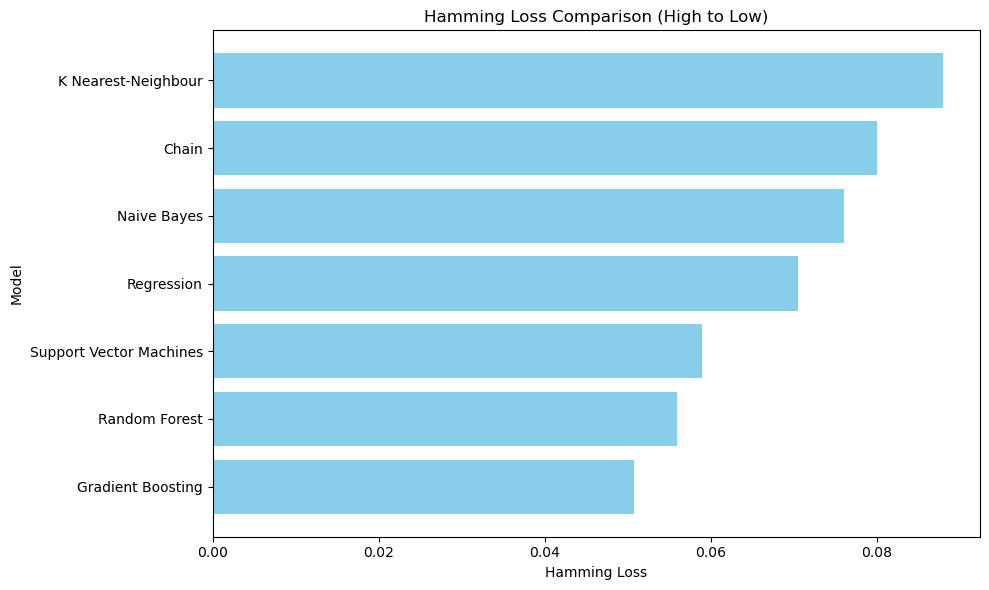

In [349]:
model_names = ["Regression", "Chain", "Random Forest", "Naive Bayes", "Gradient Boosting", "K Nearest-Neighbour", "Support Vector Machines"]
all_hamming = [regr_hamming, chain_hamming, rf_hamming, nb_hamming, gb_hamming, knn_hamming, svm_hamming]

# Create a DataFrame for better manipulation
hamming_df = pd.DataFrame({"Model": model_names, "Hamming Loss": all_hamming})

# Sort by Hamming Loss in descending order
hamming_df = hamming_df.sort_values(by="Hamming Loss", ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(hamming_df["Model"], hamming_df["Hamming Loss"], color="skyblue")
plt.xlabel("Hamming Loss")
plt.ylabel("Model")
plt.title("Hamming Loss Comparison (High to Low)")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest loss at the top
plt.tight_layout()
plt.show()

In [365]:
all_metrics = [regr_metrics, chain_metrics, rf_metrics, nb_metrics, gb_metrics, knn_metrics, svm_metrics]

for i in all_metrics:
    i = i.loc[regr_metrics.index]


all_metrics = pd.concat(all_metrics, axis=1)
comparison_df = regex_results.merge(all_metrics, left_index=True, right_index=True)
comparison_df = comparison_df.rename(columns = {"Precision": "Precision_regex", "Recall": "Recall_regex", "F1-Score":"F1-Score_regex", "Accuracy":"Accuracy_regex"})
comparison_df.head()

,Precision_regex,Recall_regex,F1-Score_regex,Accuracy_regex,Support,Precision_regr,Recall_regr,F1-Score_regr,Accuracy_regr,Precision_chain,...,F1-Score_gb,Accuracy_gb,Precision_knn,Recall_knn,F1-Score_knn,Accuracy_knn,Precision_svm,Recall_svm,F1-Score_svm,Accuracy_svm
label,,,,,,,,,,,,,,,,,,,,,
BEHAV,0.625000,0.638298,0.631579,0.967742,47,0.0,0.000000,0.000000,0.963134,0.500000,...,0.000000,0.963134,0.666667,0.250000,0.363636,0.967742,0.0,0.000000,0.000000,0.963134
BIOCHEM,0.321429,0.750000,0.450000,0.979724,12,0.0,0.000000,0.000000,0.981567,0.000000,...,0.000000,0.981567,0.000000,0.000000,0.000000,0.976959,0.0,0.000000,0.000000,0.981567
ECOLOGY,0.363636,0.193548,0.252632,0.934562,62,0.0,0.000000,0.000000,0.935484,0.333333,...,0.125000,0.935484,0.500000,0.214286,0.300000,0.935484,0.0,0.000000,0.000000,0.935484
GENOTYPE,0.658863,0.834746,0.736449,0.870046,236,1.0,0.607143,0.755556,0.898618,1.000000,...,0.845361,0.930876,0.930233,0.714286,0.808081,0.912442,1.0,0.732143,0.845361,0.930876
GEN_NON_PHYLO,0.600000,0.461538,0.521739,0.949309,65,0.0,0.000000,0.000000,0.898618,0.727273,...,0.484848,0.921659,0.888889,0.363636,0.516129,0.930876,1.0,0.090909,0.166667,0.907834


C:\Users\conix\AppData\Local\Temp\ipykernel_53580\1570629976.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(models))  # 'tab10' is a good choice for categorical data


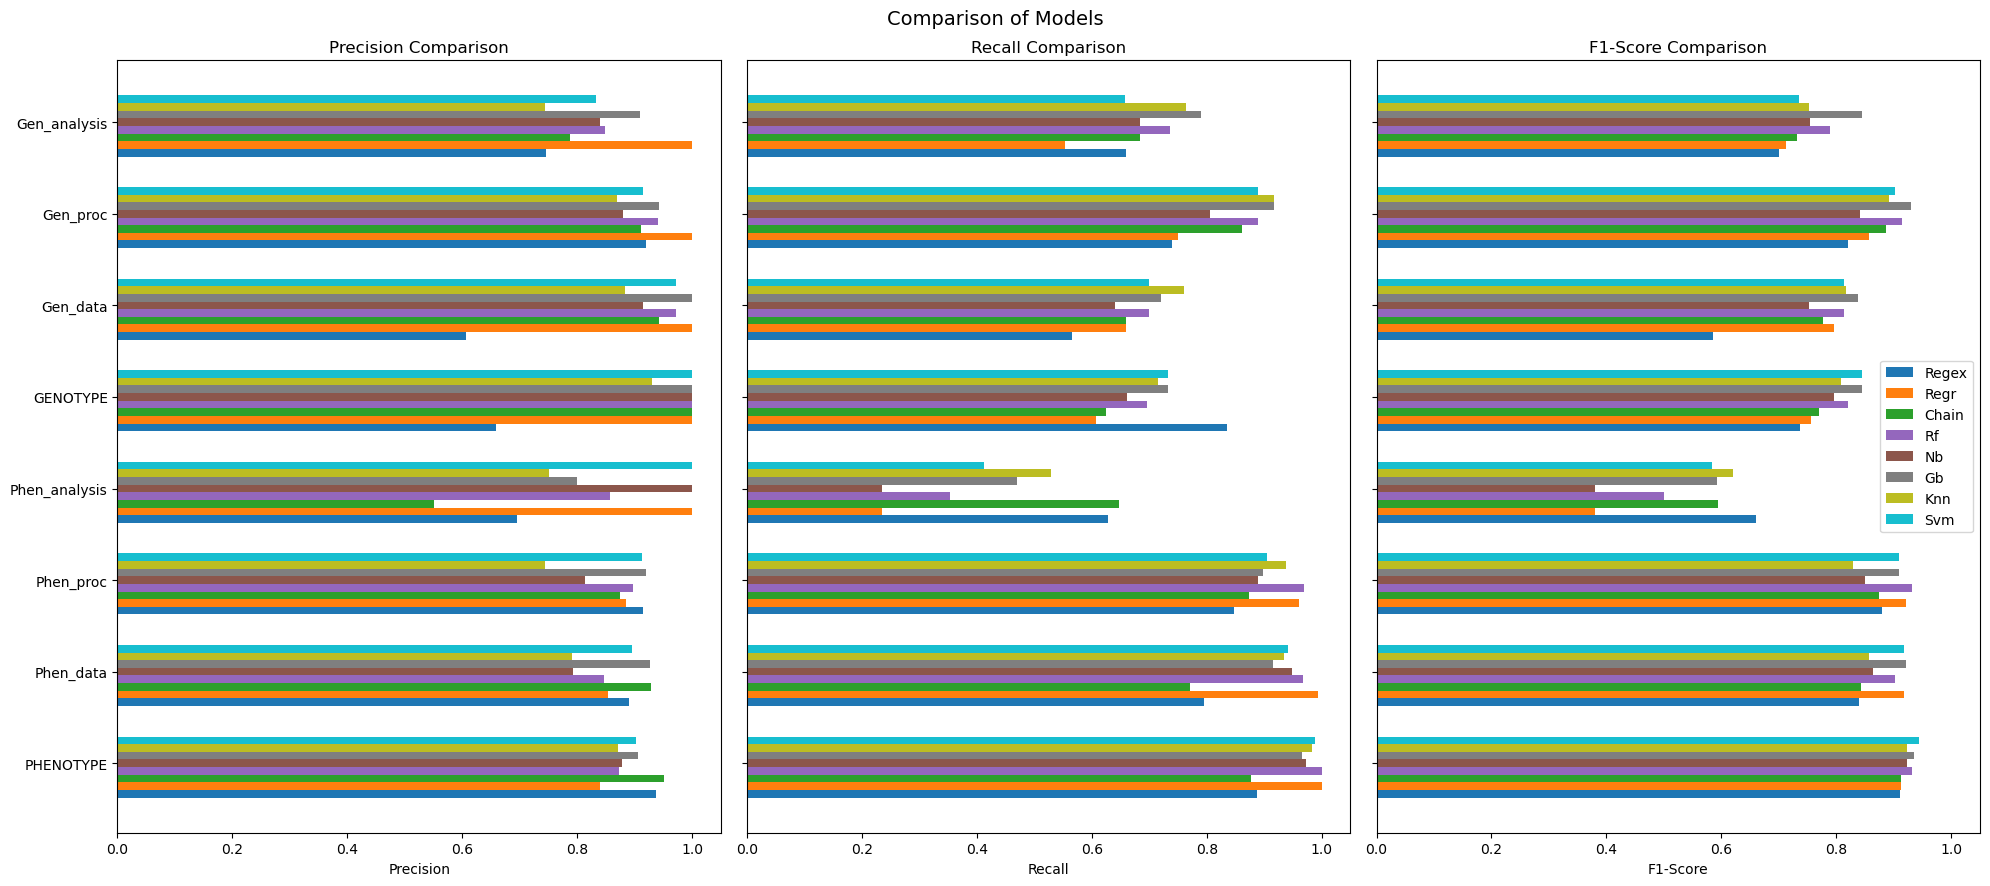

In [366]:
# List of models to include in the comparison
models = ["regex", "regr", "chain", "rf","nb", "gb", 'knn','svm']  # Add or remove as needed

# Define high-level categories for comparison
high_level =  ['PHENOTYPE', 'Phen_data', 'Phen_proc', 'Phen_analysis', 'GENOTYPE', 'Gen_data', 'Gen_proc', 'Gen_analysis'] #[i for i in comparison_df.index if comparison_df.loc[i]['Support'] > 100]#
plot_vals = comparison_df.copy()
plot_vals = plot_vals.loc[high_level]

# Prepare data for visualization
categories = plot_vals.index
bar_width = 0.8 / len(models)  # Adjust bar width based on the number of models
spacing_factor = 0.2  # Controls the gap between groups

# Plot precision, recall, and F1-score
metrics = ["Precision", "Recall", "F1-Score"]
fig, axes = plt.subplots(ncols=3, figsize=(20, 9), sharey=True, sharex=True)
axes = axes.flatten()

# Dynamically generate a colormap for the number of models
cmap = cm.get_cmap('tab10', len(models))  # 'tab10' is a good choice for categorical data
colors = [cmap(i) for i in range(len(models))]

for i, metric in enumerate(metrics):
    ax = axes[i]
    y = np.arange(len(categories)) * (1 + spacing_factor)  # Y-axis positions

    # Loop through models and plot each
    for j, model in enumerate(models):
        model_values = plot_vals[f"{metric}_{model}"]
        ax.barh(y + (j - len(models) / 2) * bar_width, model_values, bar_width, 
                label=model.capitalize(), color=colors[j % len(colors)])

    # Add labels and title
    ax.set_title(f"{metric} Comparison", fontsize=12)
    ax.set_yticks(y)
    ax.set_yticklabels(categories, fontsize=10)
    ax.set_xlabel(metric)
axes[2].legend()

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle("Comparison of Models", fontsize=14)

# Display the plot
fig.tight_layout()
plt.show()


C:\Users\conix\AppData\Local\Temp\ipykernel_53580\3745283197.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(models))  # 'tab10' is a good choice for categorical data


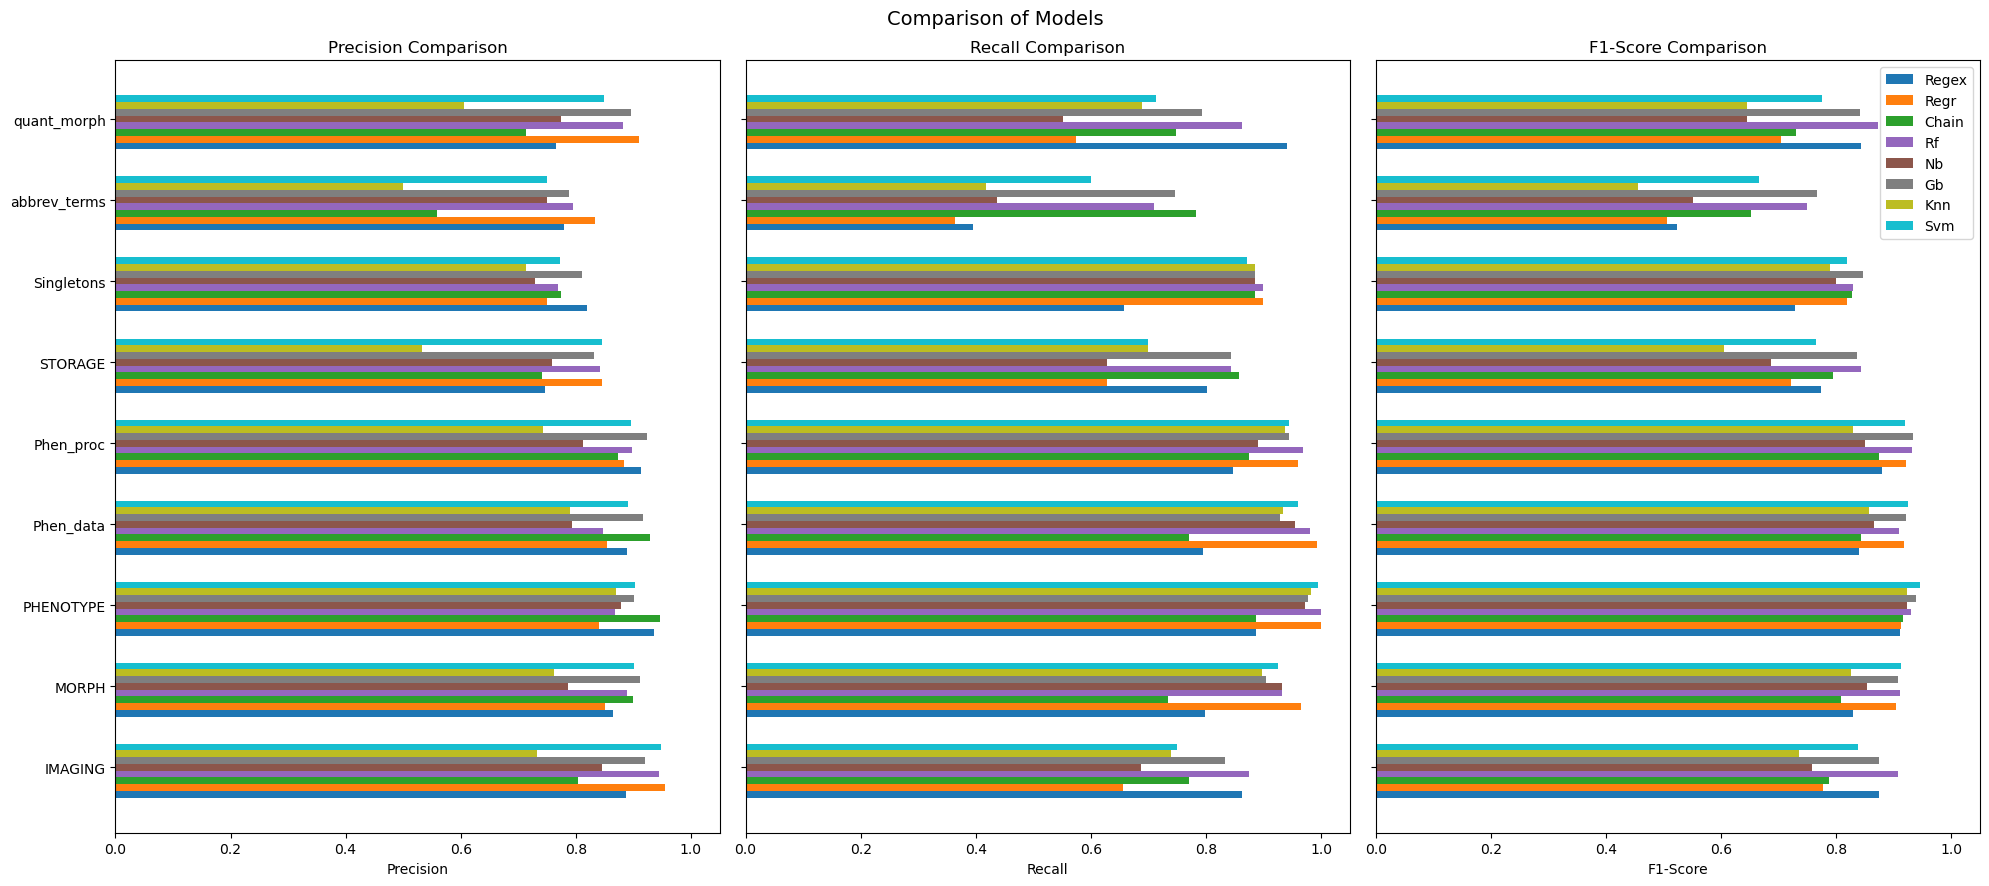

In [352]:
# List of models to include in the comparison

# Define high-level categories for comparison
high_level =  [i for i in comparison_df.index if comparison_df.loc[i]['Support'] > 300]
plot_vals = comparison_df.copy()
plot_vals = plot_vals.loc[high_level]

# Prepare data for visualization
categories = plot_vals.index
bar_width = 0.8 / len(models)  # Adjust bar width based on the number of models
spacing_factor = 0.2  # Controls the gap between groups

# Plot precision, recall, and F1-score
metrics = ["Precision", "Recall", "F1-Score"]
fig, axes = plt.subplots(ncols=3, figsize=(20, 9), sharey=True, sharex=True)
axes = axes.flatten()

# Dynamically generate a colormap for the number of models
cmap = cm.get_cmap('tab10', len(models))  # 'tab10' is a good choice for categorical data
colors = [cmap(i) for i in range(len(models))]

for i, metric in enumerate(metrics):
    ax = axes[i]
    y = np.arange(len(categories)) * (1 + spacing_factor)  # Y-axis positions

    # Loop through models and plot each
    for j, model in enumerate(models):
        model_values = plot_vals[f"{metric}_{model}"]
        ax.barh(y + (j - len(models) / 2) * bar_width, model_values, bar_width, 
                label=model.capitalize(), color=colors[j % len(colors)])

    # Add labels and title
    ax.set_title(f"{metric} Comparison", fontsize=12)
    ax.set_yticks(y)
    ax.set_yticklabels(categories, fontsize=10)
    ax.set_xlabel(metric)
axes[2].legend()

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle("Comparison of Models", fontsize=14)

# Display the plot
fig.tight_layout()
plt.show()


C:\Users\conix\AppData\Local\Temp\ipykernel_53580\4164896765.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(models))  # 'tab10' is a good choice for categorical data


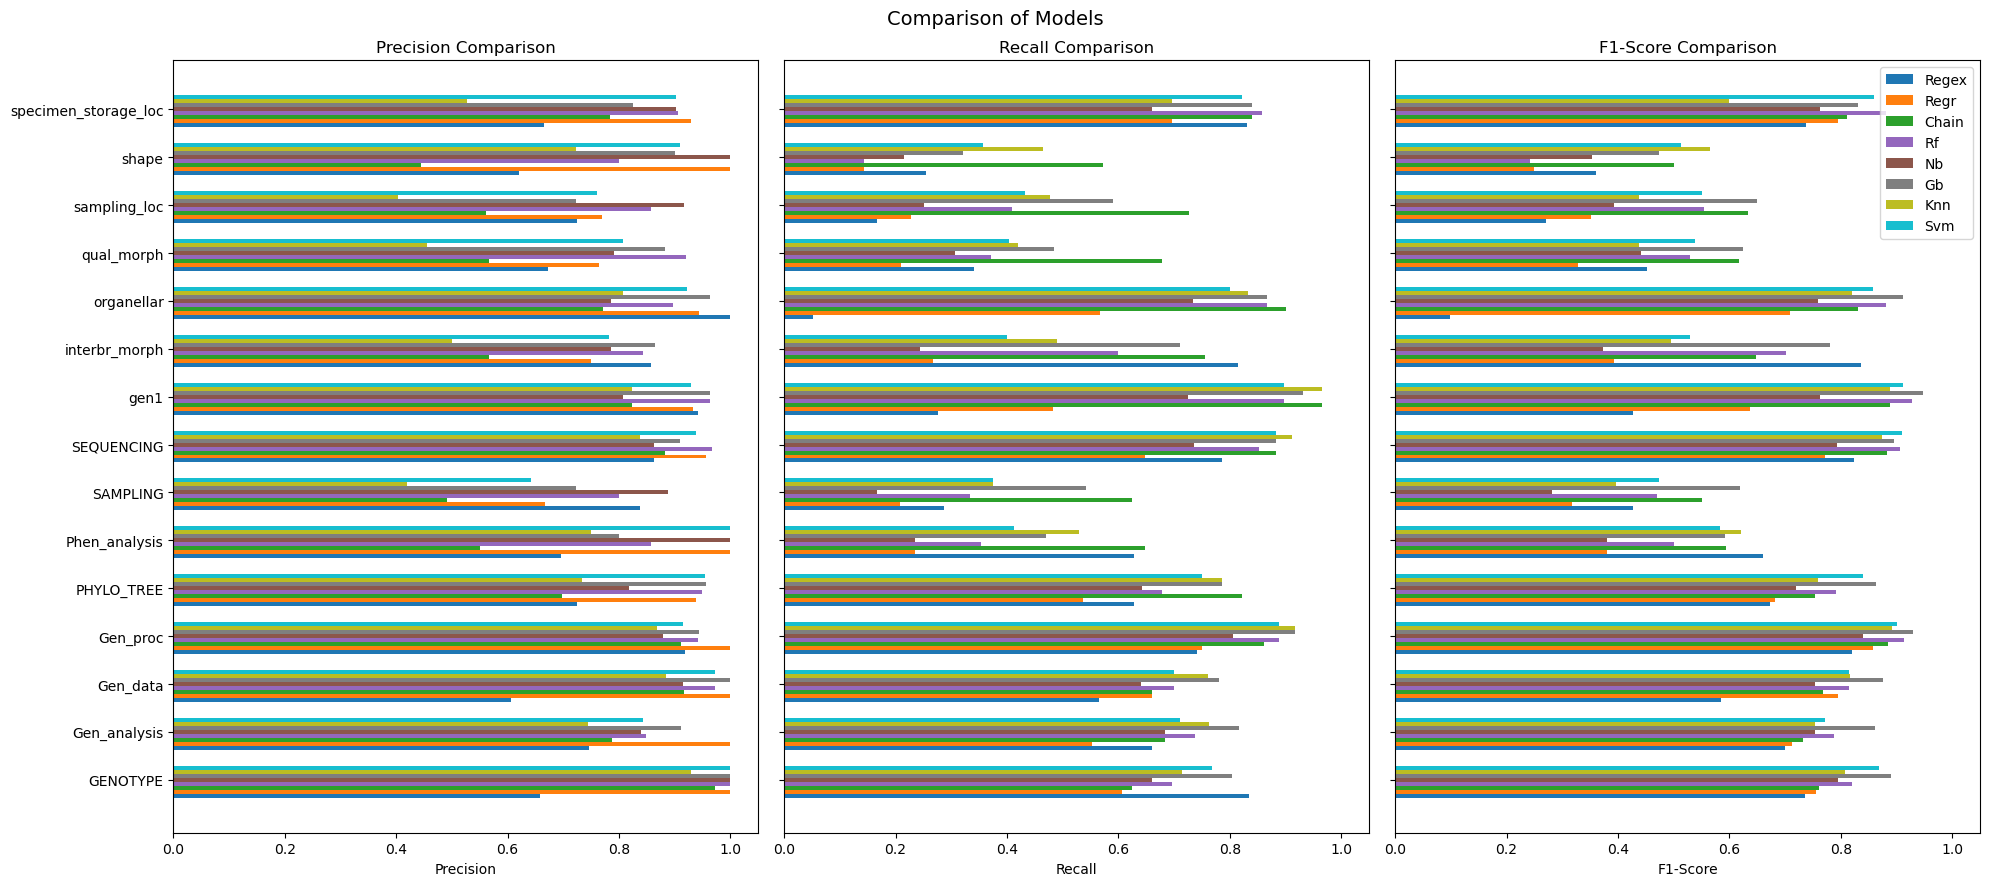

In [353]:
# List of models to include in the comparison

# Define high-level categories for comparison
high_level =  [i for i in comparison_df.index if (comparison_df.loc[i]['Support'] > 100) and (comparison_df.loc[i]['Support'] < 300)]
plot_vals = comparison_df.copy()
plot_vals = plot_vals.loc[high_level]

# Prepare data for visualization
categories = plot_vals.index
bar_width = 0.8 / len(models)  # Adjust bar width based on the number of models
spacing_factor = 0.2  # Controls the gap between groups

# Plot precision, recall, and F1-score
metrics = ["Precision", "Recall", "F1-Score"]
fig, axes = plt.subplots(ncols=3, figsize=(20, 9), sharey=True, sharex=True)
axes = axes.flatten()

# Dynamically generate a colormap for the number of models
cmap = cm.get_cmap('tab10', len(models))  # 'tab10' is a good choice for categorical data
colors = [cmap(i) for i in range(len(models))]

for i, metric in enumerate(metrics):
    ax = axes[i]
    y = np.arange(len(categories)) * (1 + spacing_factor)  # Y-axis positions

    # Loop through models and plot each
    for j, model in enumerate(models):
        model_values = plot_vals[f"{metric}_{model}"]
        ax.barh(y + (j - len(models) / 2) * bar_width, model_values, bar_width, 
                label=model.capitalize(), color=colors[j % len(colors)])

    # Add labels and title
    ax.set_title(f"{metric} Comparison", fontsize=12)
    ax.set_yticks(y)
    ax.set_yticklabels(categories, fontsize=10)
    ax.set_xlabel(metric)
axes[2].legend()

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle("Comparison of Models", fontsize=14)

# Display the plot
fig.tight_layout()
plt.show()

C:\Users\conix\AppData\Local\Temp\ipykernel_53580\4099618136.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(models))  # 'tab10' is a good choice for categorical data


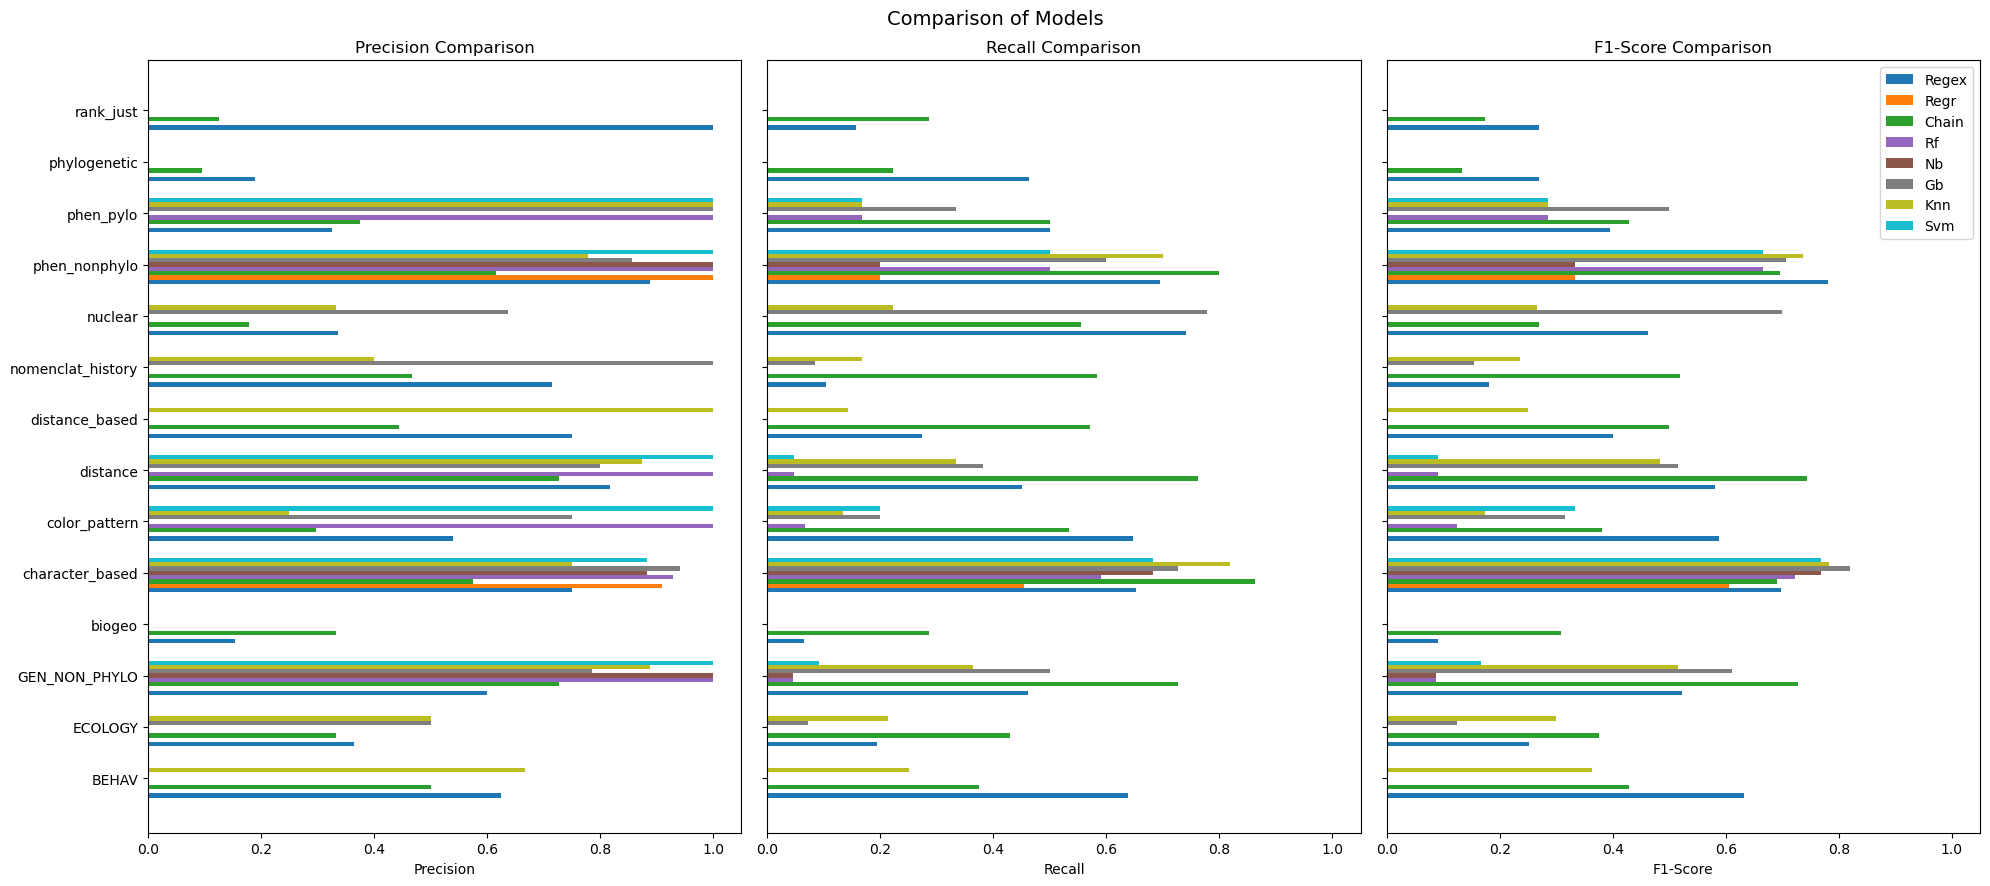

In [354]:
# List of models to include in the comparison

# Define high-level categories for comparison
high_level =  [i for i in comparison_df.index if (comparison_df.loc[i]['Support'] > 20) and (comparison_df.loc[i]['Support'] < 100)]
plot_vals = comparison_df.copy()
plot_vals = plot_vals.loc[high_level]

# Prepare data for visualization
categories = plot_vals.index
bar_width = 0.8 / len(models)  # Adjust bar width based on the number of models
spacing_factor = 0.2  # Controls the gap between groups

# Plot precision, recall, and F1-score
metrics = ["Precision", "Recall", "F1-Score"]
fig, axes = plt.subplots(ncols=3, figsize=(20, 9), sharey=True, sharex=True)
axes = axes.flatten()

# Dynamically generate a colormap for the number of models
cmap = cm.get_cmap('tab10', len(models))  # 'tab10' is a good choice for categorical data
colors = [cmap(i) for i in range(len(models))]

for i, metric in enumerate(metrics):
    ax = axes[i]
    y = np.arange(len(categories)) * (1 + spacing_factor)  # Y-axis positions

    # Loop through models and plot each
    for j, model in enumerate(models):
        model_values = plot_vals[f"{metric}_{model}"]
        ax.barh(y + (j - len(models) / 2) * bar_width, model_values, bar_width, 
                label=model.capitalize(), color=colors[j % len(colors)])

    # Add labels and title
    ax.set_title(f"{metric} Comparison", fontsize=12)
    ax.set_yticks(y)
    ax.set_yticklabels(categories, fontsize=10)
    ax.set_xlabel(metric)
axes[2].legend()

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle("Comparison of Models", fontsize=14)

# Display the plot
fig.tight_layout()
plt.show()

In [327]:
comparison_df.to_csv(r'C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\classification_metrics.csv')